# Isolation Forest – Anomaly Detection

This notebook trains and evaluates an Isolation Forest model for fraud detection.

Key objectives:
- Train the model using only normal (non-fraud) transactions
- Evaluate performance on a mixed validation set
- Analyze anomaly scores and classification performance
- Do NOT persist the model unless it is selected as the final deployment model


In [1]:
# -----------------------------
# Imports & Load Preprocessing Artifacts
# -----------------------------
import sys
import os

# Add project root to Python path
sys.path.append(os.path.abspath(".."))

import numpy as np
import joblib

from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

from src.config import RANDOM_STATE

# Load preprocessing artifacts
ARTIFACT_DIR = "../models"

X_train_scaled = np.load(f"{ARTIFACT_DIR}/X_train_scaled.npy")
X_val_scaled = np.load(f"{ARTIFACT_DIR}/X_val_scaled.npy")
y_val = np.load(f"{ARTIFACT_DIR}/y_val.npy")

print("Artifacts loaded successfully")
print("Train shape:", X_train_scaled.shape)
print("Validation shape:", X_val_scaled.shape)
print("Validation labels shape:", y_val.shape)


Artifacts loaded successfully
Train shape: (227452, 38)
Validation shape: (57355, 38)
Validation labels shape: (57355,)


In [2]:
# -----------------------------
# Train Isolation Forest
# -----------------------------
# Isolation Forest isolates anomalies instead of profiling normal points.
# The contamination parameter reflects an estimate of the anomaly proportion.

iso_forest = IsolationForest(
    n_estimators=200,
    max_samples="auto",
    contamination=0.01,   # intentionally higher than true fraud rate
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train ONLY on normal transactions
iso_forest.fit(X_train_scaled)

print("Isolation Forest training completed.")


Isolation Forest training completed.


In [3]:
# -----------------------------
# Anomaly Scoring
# -----------------------------
# Isolation Forest outputs:
#  -1 → anomaly
#   1 → normal
# We convert this into a binary fraud prediction:
#   1 → fraud
#   0 → normal

# Predict anomalies on validation set
y_pred_if = iso_forest.predict(X_val_scaled)

# Convert to fraud labels
# IF: -1 = anomaly, 1 = normal
y_pred_if = np.where(y_pred_if == -1, 1, 0)

# Anomaly scores (the lower, the more anomalous)
if_scores = -iso_forest.decision_function(X_val_scaled)

print("Predictions generated.")
print("Predicted fraud count:", y_pred_if.sum())


Predictions generated.
Predicted fraud count: 870


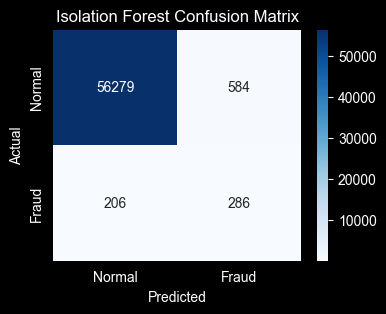

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_if)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Fraud"],
            yticklabels=["Normal", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Isolation Forest Confusion Matrix")
plt.show()


## Confusion Matrix Interpretation

The confusion matrix summarizes the trade-off made by the Isolation Forest model:

- **True Positives (286)**: Fraudulent transactions correctly identified.
- **False Negatives (206)**: Fraud cases missed by the model, representing potential financial risk.
- **False Positives (584)**: Legitimate transactions incorrectly flagged as fraud, leading to customer friction.
- **True Negatives (56,279)**: Legitimate transactions correctly classified.

The model prioritizes **recall over precision**, successfully detecting a majority of fraudulent transactions while accepting a higher number of false positives. This behavior is suitable for fraud detection systems, where missing fraudulent activity is typically more costly than investigating additional flagged transactions.


In [4]:
# -----------------------------
# Evaluation Metrics
# -----------------------------
# Evaluate Isolation Forest predictions against true labels

precision = precision_score(y_val, y_pred_if)
recall = recall_score(y_val, y_pred_if)
f1 = f1_score(y_val, y_pred_if)
roc_auc = roc_auc_score(y_val, if_scores)

print("Isolation Forest Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_if))


Isolation Forest Performance:
Precision: 0.3287
Recall:    0.5813
F1-score:  0.4200
ROC-AUC:   0.9497

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.33      0.58      0.42       492

    accuracy                           0.99     57355
   macro avg       0.66      0.79      0.71     57355
weighted avg       0.99      0.99      0.99     57355



## Isolation Forest Summary

Isolation Forest demonstrates strong anomaly ranking performance with a high ROC-AUC score. The model captures a significant portion of fraudulent transactions without using labels during training. While precision is moderate due to class imbalance, recall remains strong, making the model suitable as a baseline anomaly detection approach.
